In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import sys

In [2]:
GRID_SIZE = 10
LAYER_1 = 12
LAYER_2 = 16
GOAL_X = 5
GOAL_Y = 5
MOVES = torch.tensor([
    # N          S         E         W          Stay
    [1,0,0,0],[-1,0,0,0],[0,1,0,0],[0,-1,0,0],[0,0,0,0.0]
])

In [3]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(4, LAYER_1)  # X, Y, GOAL_X, GOAL_Y
        self.fc2 = nn.Linear(LAYER_1, LAYER_2)
        self.fc3 = nn.Linear(LAYER_2, 5)  # Pre-probability of N, S, E, W, Stay

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x),dim=-1) 
        # x = torch.sigmoid(self.fc3(x)) # Alternative: Categorical just needs positive inputs
        return x

In [138]:
def rand_initial_state():
    # mult by 1.0 to make it a float tensor
    return torch.tensor([1.0*np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE), GOAL_X, GOAL_Y])

def step(x, a, search_prob=0.002): 
    if np.random.rand() > search_prob:
        action = a
    else:
        action = np.random.randint(5)
    xnew = (x + MOVES[action])%GRID_SIZE
    if xnew[0] == xnew[2] and xnew[1] == xnew[3]:
        r = 1
    else:
        r = 0
    return xnew, torch.tensor(r)

def sample_policy(num_steps=100):
    x = rand_initial_state() # state
    r = 0
    i = 0
    states = []
    actions = []
    rewards = []
    while i < num_steps:
        p = net(x)
        m = Categorical(p)
        a = m.sample()        
        xnew, r = step(x,a)
        states.append(x)
        actions.append(float(a))
        rewards.append(float(r))
        x = xnew
        i += 1
    return states, actions, rewards

def compute_rewards(rewards,gamma=1.0):
    running_add = 0
    for i in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[i]
    return running_add


def visualize():
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            p = net(torch.tensor([1.0*x,y,GOAL_X, GOAL_Y])).detach()
            dx = sum([MOVES[i][0]*p[i] for i in range(len(p))])
            dy = sum([MOVES[i][1]*p[i] for i in range(len(p))])
            plt.arrow(x,y,dx,dy,length_includes_head=True, head_width=0.2, head_length=0.2)
        
    plt.xlim(-1,GRID_SIZE)
    plt.ylim(-1,GRID_SIZE);
    plt.gca().set_aspect(1)  

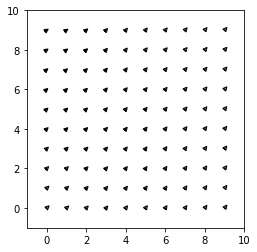

In [136]:
net = PolicyNet()
visualize()

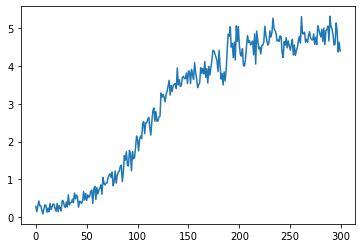

In [137]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0025)
losses = []

EPOCHS = 300
BATCH_SIZE = 100
num_steps = 15

for i in range(EPOCHS):

    # Create a batch
    states_batch = []
    actions_batch = []
    rewards_batch = []
    
    for j in range(BATCH_SIZE):
        states, actions, rewards = sample_policy(num_steps=num_steps) #running a network for length T = 15
        rew = compute_rewards(rewards, gamma=0.99)
        states_batch.extend(states)
        actions_batch.extend(actions)
        rewards_batch.append(rew)
    
    #formatting these tensors
    states_batch = torch.stack(states_batch) 
    actions_batch = torch.FloatTensor(actions_batch).long()
    rewards_batch= torch.FloatTensor(rewards_batch)
    
    # Estimate gradient (there is probably a nice torch way to compute the log_probs)
    outputs = net(states_batch)
    log_probs = Categorical(outputs).log_prob(actions_batch)
    
    log_probs = torch.reshape(log_probs, (BATCH_SIZE, num_steps))
    log_means = log_probs.mean(1)
    loss = (-rewards_batch* log_means).mean()
    losses.append(loss)
    
    # Backprop gradient and take an optimization step
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()    
    
    sys.stdout.write("\rEpoch %d: Loss: %f      " % (i,loss))
    
plt.plot(losses);

In [139]:
torch.cuda.is_available()

False

In [4]:
cuda = torch.device('cuda')